#### Human Protein Exploration

Using reference from this kernel https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/71039

In [1]:
import fastai
fastai.__version__

'1.0.28'

In [2]:
from fastai import *
from fastai.vision import *
from fastai.vision.image import *
import torch
import torch.nn as nn
import torchvision
import cv2

In [3]:
np.random.seed(42)

In [4]:
path = Path('data')

In [5]:
path.ls()

[PosixPath('data/first-submission.csv'),
 PosixPath('data/first-submission-384.csv'),
 PosixPath('data/train.csv'),
 PosixPath('data/models'),
 PosixPath('data/test'),
 PosixPath('data/train')]

In [6]:
train_df = pd.read_csv(path / 'train.csv')

In [7]:
train_df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [8]:
RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}

In [9]:
class Resnet4Channel(nn.Module):
    
    def __init__(self, encoder_depth=34, pretrained=True, num_classes=28):
        super().__init__()
        encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        w = encoder.conv1.weight
        
#         (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#         (relu): ReLU(inplace)
#         (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight = nn.Parameter(torch.cat((w, torch.zeros(64, 1, 7, 7)), dim=1))
        self.bn1 = encoder.bn1
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4
        
        self.avgpool = encoder.avgpool
        self.fc = nn.Linear(512 * (1 if encoder_depth == 34 else 4), num_classes)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [10]:
def open_4_channel(fname):
    fname = str(fname)
    if fname.endswith(".png"):
        fname = fname[:-4]
        
    colors = ['red', 'green', 'blue', 'yellow']
    flags = cv2.IMREAD_GRAYSCALE
    
    img = [cv2.imread(fname + '_' + color + '.png', flags).astype(np.float32) / 255 for color in colors]
    
    x = np.stack(img, axis=-1)
    
    return Image(pil2tensor(x, np.float32).float())

In [11]:
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
      .random_split_by_pct(0.2)
      .label_from_df(sep=' ', classes=[str(i) for i in range(28)]))

In [12]:
src.train.x.open = open_4_channel
src.train.x.create_func = open_4_channel

In [13]:
src.valid.x.open = open_4_channel
src.valid.x.create_func = open_4_channel

In [14]:
test_ids = list(sorted(set(fname.split('_')[0] for fname in os.listdir(path / 'test'))))

In [15]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [16]:
test_fnames[:5]

[PosixPath('data/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('data/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('data/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [17]:
src.add_test(test_fnames, label='0');

In [18]:
src.test.x.open = open_4_channel
src.test.x.create_func = open_4_channel

In [19]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [20]:
trn_tfms, _ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1, max_lighting=0.05, max_warp=0.)

In [21]:
data = (src.transform((trn_tfms, _), size=512).databunch(bs=16).normalize(protein_stats))

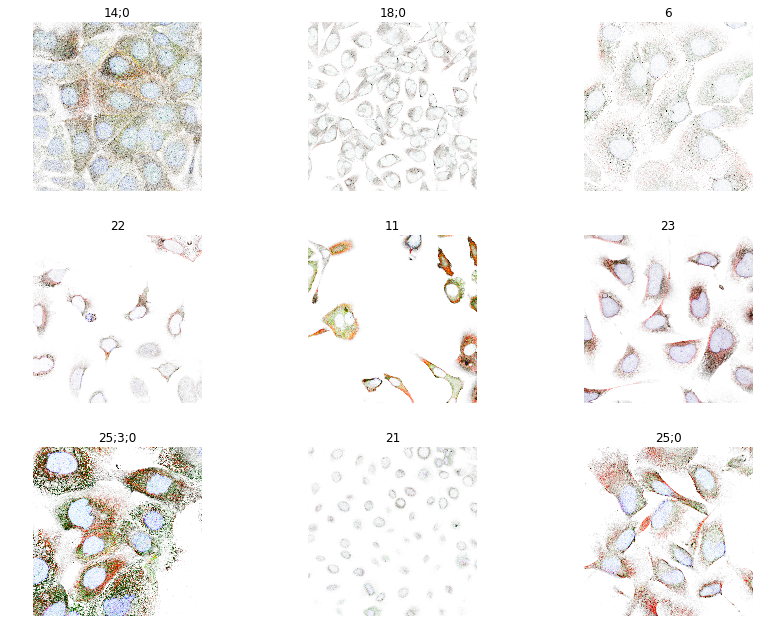

In [22]:
data.show_batch(rows=3, figsize=(12,9))

In [22]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [23]:
def _resnet_split(m): return (m[0][6],m[1])

In [24]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [25]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


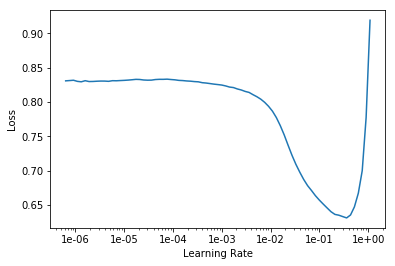

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(3, slice(1e-2))

Total time: 21:13
epoch  train_loss  valid_loss  fbeta   
1      0.138064    0.130223    0.519638  (07:11)
2      0.121375    0.113901    0.599384  (07:03)
3      0.109254    0.105000    0.630434  (06:58)



In [29]:
learn.fit_one_cycle(6, slice(1e-2))

Total time: 41:58
epoch  train_loss  valid_loss  fbeta   
1      0.112405    0.109713    0.612634  (06:57)
2      0.114021    0.117806    0.588869  (07:02)
3      0.112248    0.111904    0.599393  (06:58)
4      0.105146    0.101624    0.647685  (06:55)
5      0.099540    0.096608    0.668630  (07:03)
6      0.097772    0.095242    0.670236  (06:59)



In [30]:
learn.save("first_try")

In [32]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(1, slice(3e-5, 3e-2/5))

Total time: 09:18
epoch  train_loss  valid_loss  fbeta   
1      0.102670    0.097534    0.664589  (09:18)



In [37]:
learn.fit_one_cycle(10, slice(3e-5, 3e-3))

Total time: 1:33:05
epoch  train_loss  valid_loss  fbeta   
1      0.098003    0.097505    0.667321  (09:18)
2      0.099657    0.103062    0.648476  (09:18)
3      0.102427    0.102624    0.643805  (09:18)
4      0.100854    0.100798    0.647185  (09:18)
5      0.096854    0.094705    0.671987  (09:19)
6      0.092778    0.091236    0.682038  (09:18)
7      0.087048    0.088675    0.696263  (09:18)
8      0.083656    0.089279    0.704263  (09:18)
9      0.082293    0.084427    0.707907  (09:18)
10     0.079639    0.084153    0.711743  (09:17)



In [39]:
learn.fit_one_cycle(10, slice(3e-5, 3e-3))

Total time: 1:33:07
epoch  train_loss  valid_loss  fbeta   
1      0.081583    0.087309    0.701270  (09:18)
2      0.086665    0.094408    0.671216  (09:18)
3      0.088280    0.094042    0.673265  (09:18)
4      0.087995    0.126416    0.674713  (09:19)
5      0.085962    0.091295    0.681029  (09:19)
6      0.081092    0.086317    0.703412  (09:18)
7      0.078250    0.083931    0.713115  (09:18)
8      0.072833    0.081895    0.722025  (09:19)
9      0.068669    0.080794    0.722744  (09:19)
10     0.067794    0.080260    0.725507  (09:17)



In [40]:
learn.save("first_try-unfreeze")

In [26]:
_ = learn.load("first_try-unfreeze")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


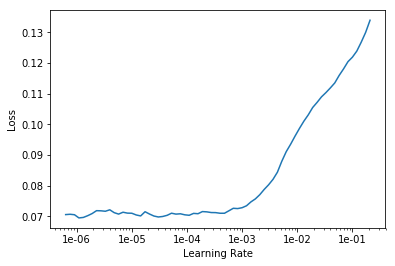

In [41]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(12, slice(3e-7, 1e-4))

epoch,train_loss,valid_loss,fbeta
1,0.068647,0.080320,0.726373
2,0.067870,0.080565,0.724015
3,0.068189,0.080563,0.726387
4,0.069928,0.080640,0.726234
5,0.065968,0.080674,0.727626


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


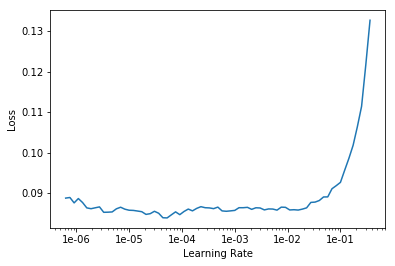

In [29]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(4, 1e-3)

Total time: 1:32:09
epoch  train_loss  valid_loss  fbeta   
1      0.074732    0.074988    0.745111  (23:29)
2      0.072929    0.074681    0.746250  (22:53)
3      0.071555    0.072902    0.751292  (22:53)
4      0.067991    0.072344    0.752452  (22:53)



In [ ]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,fbeta
1,0.068321,0.072645,0.752607
2,0.070745,0.073872,0.748336
3,0.071265,0.074927,0.740546


In [ ]:
learn.save("foobar")

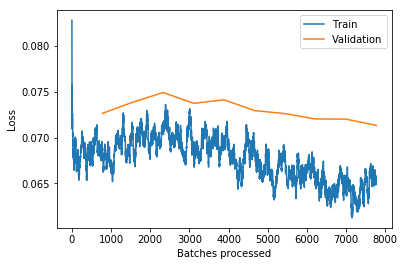

In [31]:
learn.recorder.plot_losses()

In [32]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


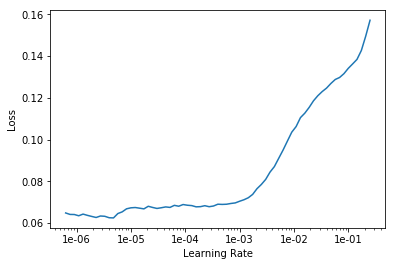

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(6, max_lr=slice(1e-6, 3e-4))

Total time: 2:59:47
epoch  train_loss  valid_loss  fbeta   
1      0.064766    0.071846    0.757455  (30:01)
2      0.066340    0.071408    0.760164  (29:57)
3      0.062435    0.071609    0.759764  (29:57)
4      0.062344    0.070658    0.759931  (29:57)
5      0.062492    0.071023    0.756754  (29:57)
6      0.061656    0.071063    0.761839  (29:57)



In [35]:
learn.save("unfreeze-386")

In [36]:
preds,_ = learn.get_preds(DatasetType.Test)

/home/deep/fastai-env/lib/python3.6/site-packages/torch/nn/functional.py:1174: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [37]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
# df.to_csv(path/'protein_predictions_datablocks.csv', header=True, index=False)
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 25


In [38]:
df.to_csv(path / 'first-submission-384.csv', header=True, index=False)

##### With above I got 0.433LB

### Training on full size

In [27]:
_ = learn.load("unfreeze-386")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


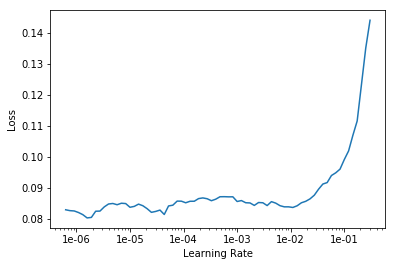

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(4, 1e-3)

Total time: 2:14:41
epoch  train_loss  valid_loss  fbeta   
1      0.073467    0.094258    0.731829  (33:59)
2      0.075996    0.074018    0.740095  (33:33)
3      0.076627    0.073548    0.754004  (33:33)
4      0.070513    0.074950    0.755241  (33:34)



In [30]:
learn.save("foobar")

In [26]:
_ = learn.load("foobar")

In [27]:
learn.fit_one_cycle(8, 1e-3)

Total time: 4:25:37
epoch  train_loss  valid_loss  fbeta   
1      0.075553    0.076059    0.747547  (33:42)
2      0.071394    0.354688    0.743623  (33:02)
3      0.076882    0.075282    0.743771  (33:07)
4      0.075499    0.156347    0.744117  (33:05)
5      0.073871    0.140842    0.735556  (33:03)
6      0.072146    0.072021    0.752412  (33:12)
7      0.067813    0.075848    0.753980  (33:11)
8      0.069224    0.071698    0.756337  (33:11)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


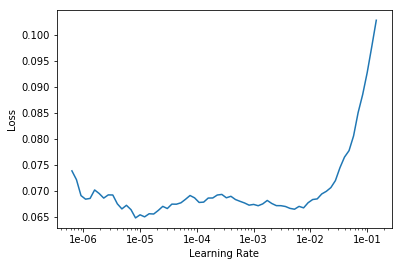

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(10, 1e-4)

Total time: 5:31:54
epoch  train_loss  valid_loss  fbeta   
1      0.066636    0.125368    0.753036  (33:07)
2      0.067291    0.071517    0.756178  (33:08)
3      0.068371    0.071513    0.756858  (33:09)
4      0.067678    0.819366    0.751765  (33:11)
5      0.069950    0.082143    0.754768  (33:12)
6      0.067879    0.071579    0.758751  (33:10)
7      0.064009    0.071002    0.757713  (33:12)
8      0.066133    0.073960    0.758117  (33:12)
9      0.066314    0.116872    0.754716  (33:13)
10     0.066465    0.082206    0.755829  (33:15)



In [30]:
learn.save("foobar")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


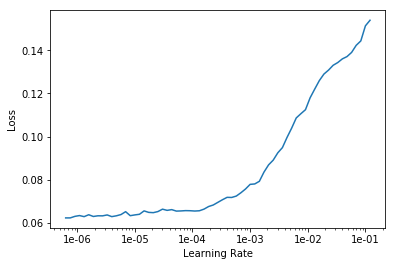

In [31]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, slice(1e-7, 1e-4))

epoch,train_loss,valid_loss,fbeta
1,0.069600,0.071427,0.759393
2,0.066684,0.071049,0.760134
3,0.070104,0.070743,0.760551


In [33]:
preds,_ = learn.get_preds(DatasetType.Test)

/home/deep/fastai-env/lib/python3.6/site-packages/torch/nn/functional.py:1174: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [34]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
# df.to_csv(path/'protein_predictions_datablocks.csv', header=True, index=False)
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 7 25


In [35]:
df.to_csv(path / 'first-submission-512.csv', header=True, index=False)